# Benchmarking Dataset Generation

This notebook is used as part of the benchmarking of the COMPASS RTC. This notebook will guide you through using the shesha simulator to generate the required wfs images for input, and the centroids and voltages for output verification.

## Notebook to script

Execute the following to convert it to a script (change it to a code cell first!)

```bash
!jupyter nbconvert --to script dataset-generate.ipynb
```

However, the script will only run properly when in the ```$SHESHA_ROOT``` folder as a working directory.

## Imports

In [2]:
import os
from shesha.supervisor.compassSupervisor import CompassSupervisor as Supervisor
import numpy as np
import matplotlib.pyplot as plt

## Setup Constants

**DEVICES:** The GPU devices being used

**THRESHOLD:** The simulator will wait for idle before running, set what 'idle' is by utilisation %

**NITER:** Number of iterations

**PARAM_FILE:** Path to the parameter file used

**WFS_FILE:** Path to the output WFS file, should be .npz extension

**CENTROIDS_FILE:** Path to the output centroids file, should be .npz extension

**VOLTAGES_FILE:** Path to the output voltages file, should be .npz extension

In [3]:
DEVICES = [0]
THRESHOLD_CPU, THRESHOLD_GPU = (20, 5)
NITER = 10000
MONITORING_FREQ = NITER
PARAM_FILE = os.path.abspath("../data/par/par4bench/scao_sh_16x16_8pix.py")
WFS_FILE = os.path.abspath("./wfs.npz")
CENTROIDS_FILE = os.path.abspath("./centroids.npz")
VOLTAGES_FILE = os.path.abspath("./voltages.npz")


def is_jupyter():
    """Check if running in jupyter"""
    try:
        if str(get_ipython()).find("ipykernel") == 1:
            return True
        return False
    except Exception:
        return False
IS_JUPYTER = is_jupyter()

DEVICES = [0]
NITER = 10000
PARAM_FILE = os.path.abspath("../data/par/par4bench/scao_sh_16x16_8pix.py")
WFS_FILE = os.path.abspath("./wfs.npz")
CENTROIDS_FILE = os.path.abspath("./centroids.npz")
VOLTAGES_FILE = os.path.abspath("./voltages.npz")

if not IS_JUPYTER:
    from argparse import ArgumentParser
    
    parser = ArgumentParser()
    parser.add_argument("file", help="Parameter .py file")
    parser.add_argument("output_wfs", help="Filename for output .npz file")
    parser.add_argument("output_centroids", help="Filename for output .npz file")
    parser.add_argument("output_voltages", help="Filename for output .npz file")
    parser.add_argument("--devices", default=DEVICES, nargs='+', help='A list of GPU devices ex. "0 1 2"', type=int)
    parser.add_argument("-n", "--niter", default=NITER, help="Number of image sets", type=int)

    args = parser.parse_args()

    DEVICES = args.devices
    NITER = args.niter
    PARAM_FILE = os.path.abspath(args.file)
    WFS_FILE = os.path.abspath(args.output_wfs)
    CENTROIDS_FILE = os.path.abspath(args.output_centroids)
    VOLTAGES_FILE = os.path.abspath(args.output_voltages)  

## Supervisor Setup

We use the built in supervisor to initialise the system components and generate the WFS images so we can save some work. We can access the simulator directly after setup due to python goodness.

In [4]:
supervisor = Supervisor(PARAM_FILE)
supervisor.config.p_loop.set_devices(DEVICES)
supervisor.initConfig()
simulator = supervisor._sim

loading: scao_sh_16x16_8pix


  0%|          | 0/1 [00:00<?, ?it/s]

->tel
*-----------------------
Computing geometry of WFS 0
r0 for WFS : 0.16  m
seeing for WFS :  0.64 "
quantum pixsize :  0.0580 "
simulated FoV :  3.71 " x  3.71 "
actual pixsize :  0.2901
actual FoV :  2.32 " x  2.32 "
number of phase points :  18
size of fft support :  64
size of HR spot support :  64
pupdiam used:  288
Generic pupil created
nphotons :  1577393.3612004826
->atmos
Creating turbulent layers :


100%|██████████| 284/284 [00:00<00:00, 2991.27it/s]


->dm
Pattern type : square
Computing Influence Function type :  default
->target


DM1: 100%|██████████| 2/2 [00:00<00:00, 2718.28it/s]

->wfs
->rtc
Doing imat geom...
Filtering unseen actuators... 
Done
CONTROLLER ADDED
done in 0.720416 s


Doing imat svd...
svd done in 0.228854 s
Building cmat...
Filtering  4  modes
cmat done in 0.000534 s


## Generate Dataset

The datasets are saved in the numpy compressed format ".npz". They are formatted in a dictionary of array of datasets, for example if the system has 2 WFS, then the file will contain ```{'1': [wfs1, wfs2] }```.

The following cell manually converts seperate npy save files into one single npz file by using ZIP compression (npz is just a zip). A temporary directory is used, and will be automatically cleaned up by Python.

In [8]:
from tempfile import TemporaryDirectory
import zipfile 

with TemporaryDirectory() as wfs_dir, \
    TemporaryDirectory() as centroids_dir, \
    TemporaryDirectory() as voltages_dir:

    dirs = [wfs_dir, centroids_dir, voltages_dir]

    with zipfile.ZipFile(WFS_FILE, mode='w', compression=zipfile.ZIP_DEFLATED) as wfs_zf, \
        zipfile.ZipFile(CENTROIDS_FILE, mode='w', compression=zipfile.ZIP_DEFLATED) as centroids_zf, \
        zipfile.ZipFile(VOLTAGES_FILE, mode='w', compression=zipfile.ZIP_DEFLATED) as voltages_zf:
    
        zf = [wfs_zf, centroids_zf, voltages_zf]
        for i in range(NITER):
            simulator.next()
            wfs_arr = np.array([supervisor.getWfsImage(j) for j in range(len(simulator.wfs.d_wfs))])
            centroids_arr = np.array([supervisor.getCentroids(j) for j in range(len(simulator.rtc.d_control))])
            voltages_arr = np.array([supervisor.getVoltage(j) for j in range(len(simulator.rtc.d_control))])

            arrays = [wfs_arr, centroids_arr, voltages_arr]
            filename = "{}.npy".format(i)
            filepaths = [os.path.join(d, filename) for d in dirs]

            for path, arr, z in zip(filepaths, arrays, zf):
                np.save(path, arr)
                z.write(path, filename)
                    

Perform a check after the file is created

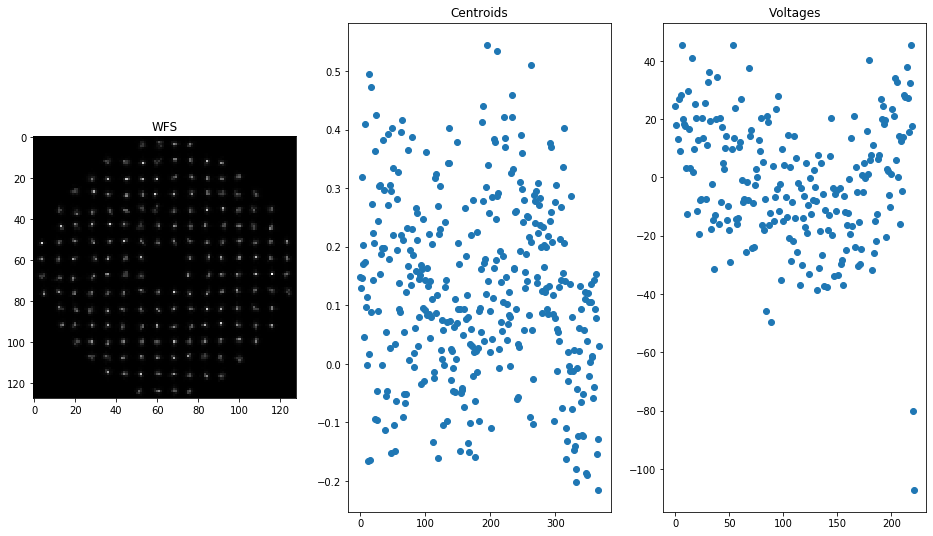

In [32]:
fig = plt.figure(figsize=(16,9))
data = []
for i, filepath in enumerate([WFS_FILE, CENTROIDS_FILE, VOLTAGES_FILE]):
    file = np.load(filepath)
    data.append(file["1"][0])
    
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("WFS")
_ = ax1.imshow(data[0], cmap="gray")
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("Centroids")
_ = ax2.plot(data[1], 'o')
ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("Voltages")
_ = ax3.plot(data[2], 'o')
fig.show()

In [14]:
simulator.wfs.d_wfs[0].d_binimg

-----------------------
carma_obj<f> object on GPU0
ndims = 2
dim[0] = 128
dim[1] = 128
nbElem = 16384
sizeof(f) = 4
-----------------------

In [10]:
simulator.wfs.d_wfs[0].set_binimg(img[0], 128 * 128)

0

In [24]:
simulator.doCentroids(0)
simulator.doControl(0)
simulator.doClipping(0)
simulator.applyControl(0)

In [12]:
plt.imshow(np.array(simulator.wfs.d_wfs[0].d_binimg))